### Import neccessary packages ###

In [44]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Read the file ###

In [45]:
# load the file
gg_data = pd.read_csv('google.csv', keep_default_na=False)


In [46]:
# Check the initial shape of the data. The result is 2930 rows, 82 columns
print ('Initial shape of the gg_data is', gg_data.shape)


Initial shape of the gg_data is (2768, 7)


In [47]:
# See the initial data types of each columns
gg_data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [48]:
# Check duplicates row in dataframe. The result is we find no duplicates in the data row.
gg_data[gg_data.duplicated(keep=False)]

,Date,Open,High,Low,Close,Adj Close,Volume


In [49]:
# Removing spaces from column names to have better access
gg_data.columns = gg_data.columns.str.replace(' ',"")

# Change the empty field into NAN
gg_data.replace(to_replace = "", value = np.NAN,inplace=True)

# See all the columns in dataframe 
gg_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')

In [50]:
# Check how many columns contains empty value (empty row)
gg_data.columns[gg_data.isnull().sum() != 0].size

0

In [51]:
# Display which columns has empty value (empty row)
gg_data.columns[gg_data.isnull().sum() != 0]

Index([], dtype='object')

In [52]:
# See how many values are empty in each column which has empty value (empty row)
gg_data.loc[:,gg_data.columns[gg_data.isnull().sum() != 0]].isnull().sum().sort_values()

Series([], dtype: float64)

## DATA CLEANING ##

In [53]:
gg_data.sample(10)

,Date,Open,High,Low,Close,AdjClose,Volume
999,2012-06-14,278.836426,280.709259,276.461884,277.718719,277.718719,4720100
333,2009-10-22,273.222961,275.706787,272.229401,275.254730,275.254730,4703300
18,2008-07-24,246.745163,246.829605,236.273270,236.273270,236.273270,7127700
1667,2015-02-11,532.370361,535.503113,530.458862,533.036682,533.036682,1377800
2004,2016-06-14,716.479980,722.469971,713.119995,718.270020,718.270020,1306100
166,2009-02-25,169.969513,175.011719,168.364944,169.716156,169.716156,12961800
1383,2013-12-24,553.882507,554.016663,550.469727,552.327637,552.327637,1477800
285,2009-08-14,229.894760,230.093460,226.968781,228.513733,228.513733,3371900
1881,2015-12-16,750.000000,760.590027,739.434998,758.090027,758.090027,1993300
1335,2013-10-16,440.072754,446.262482,439.148773,446.113464,446.113464,4041300


In [54]:
# Set Order column as index
gg_data.set_index('Date', inplace=True)

## DATA OBSERVATION ##

O foco aqui é a coluna close, referente ao preço de fechamento, vamos ver quais colunas tem mais corelaç~ao com ela, utilizando a biblioteca seaborn e a função heatmap.

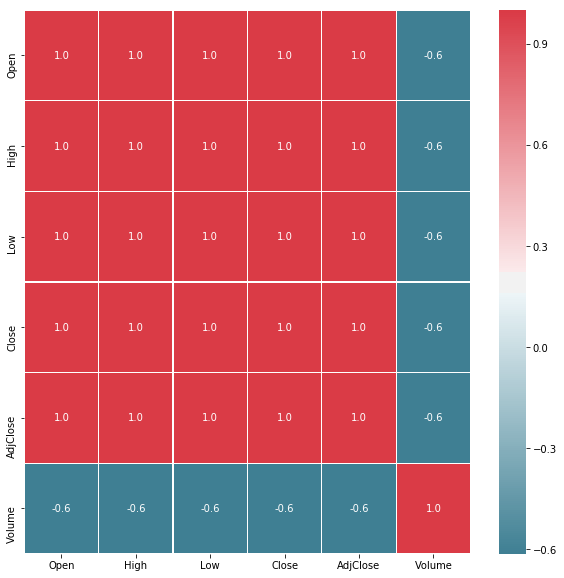

In [55]:
# Display the correlation heatmap

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
colormap = sbn.diverging_palette(220, 10, as_cmap=True)
sbn.heatmap(gg_data.corr(), cmap=colormap, annot=True, linewidths=.05, fmt='.1f', ax=ax)

In [56]:
# Sorted the most important features correlated to Sale Price
corr = gg_data.corr() #perason correlation 
corr.sort_values(["Close"], ascending = False, inplace = True)
print("Most important feature by perason correlation")
print(corr.Close)

Most important feature by perason correlation
Close       1.000000
AdjClose    1.000000
Low         0.999873
High        0.999835
Open        0.999681
Volume     -0.610806
Name: Close, dtype: float64


Based on correlation heatmap above, some features which has high correlation with 'SalePrice' are: OverallQual,GrLivArea,ExterQual, KitchenQual, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, BsmtQual This correlation will be proven after we run our algorithm modelling.

In [57]:
# Show the correlation summary
gg_data.corr()

,Open,High,Low,Close,AdjClose,Volume
Open,1.000000,0.999870,0.999819,0.999681,0.999681,-0.609923
High,0.999870,1.000000,0.999789,0.999835,0.999835,-0.607476
Low,0.999819,0.999789,1.000000,0.999873,0.999873,-0.613540
Close,0.999681,0.999835,0.999873,1.000000,1.000000,-0.610806
AdjClose,0.999681,0.999835,0.999873,1.000000,1.000000,-0.610806
Volume,-0.609923,-0.607476,-0.613540,-0.610806,-0.610806,1.000000


In [58]:
# Get information from column 'Close'
# We will see that the SalePrice minimum value is greater than zero.
gg_data['Close'].describe()

count    2768.000000
mean      556.065652
std       313.571265
min       127.888214
25%       287.367203
50%       513.982025
75%       771.885010
max      1287.579956
Name: Close, dtype: float64

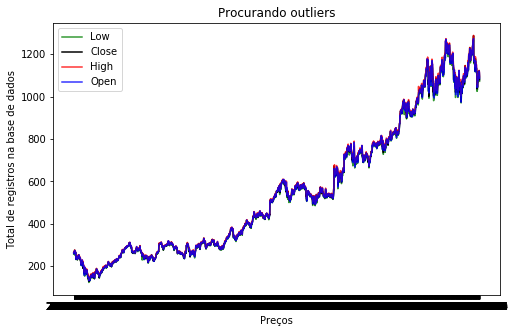

In [59]:
# Looking for outliers
plt.figure(figsize=(8,5))
plt.plot(gg_data.Low, '-g', alpha = 0.8, label='Low')
plt.plot(gg_data.Close, 'k-', label='Close')
plt.plot(gg_data.High, '-r', alpha = 0.8, label='High')
plt.plot(gg_data.Open, '-b', alpha = 0.8, label='Open')
plt.title("Procurando outliers")
plt.legend(loc='upper left')
plt.xlabel("Preços")
plt.ylabel("Total de registros na base de dados")
plt.savefig('precos.png')
plt.show()

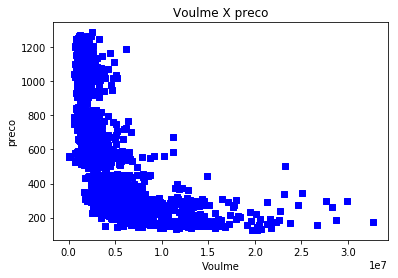

In [60]:
# Voulme X preco
plt.scatter(x = gg_data.Volume, y = gg_data.Close, c = "blue", marker = "s")
plt.title("Voulme X preco")
plt.xlabel("Voulme")
plt.ylabel("preco")
plt.savefig('vol_price.png', dpi=100)
plt.show()

We see the distribution of label prices

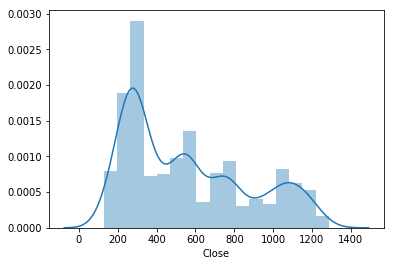

In [61]:
# Check the distribution of label values Close price
sbn.distplot(gg_data['Close'])


In [62]:
# Skewness metric
gg_data['Close'].skew()

0.6387987773928498

The skewness value > 1 ==> data is highly skewed. (Ref: https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55 ). We can use Logarithm transformation to 
normalize the SalePrice data. A normalized label helps in better modeling the close price between label values and independent features.

In [63]:
normalized_saleprice = np.log(gg_data['Close'])
print('Check skewness:', normalized_saleprice.skew())

Check skewness: -0.010577797260174262


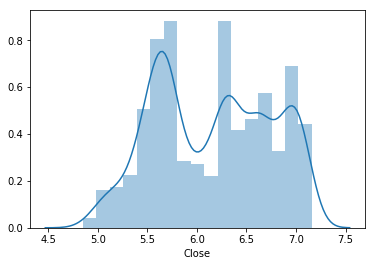

In [64]:
sbn.distplot(normalized_saleprice)

In [65]:
# We check the type of all columns in dataframe
gg_data.dtypes

Open        float64
High        float64
Low         float64
Close       float64
AdjClose    float64
Volume        int64
dtype: object

## Divide the gg_data into trainset and testset, then normalize x_train an x_test by using StandardScaler

In [66]:
# We use sklearn.model_selection import train_test_split to split the dataframe into trainset and testset
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
   
#Divide data into training set and test set = 70 % : 30%
trainset, testset = train_test_split(gg_data, test_size=0.3)

# Convert all columns with type integer (except SalePrice) to float 32 to save some memory.
trainset = trainset.astype('float64')#MUDEI DEPOIS QUE TUDO FUNCIONOU
testset = testset.astype('float64')
    
x_trainset = trainset.drop(['Close'],axis=1)
x_testset = testset.drop(['Close'],axis=1)
 
scaler = StandardScaler()

x_train = scaler.fit_transform(trainset.drop(['Close'],axis=1).values)
y_train = scaler.fit_transform(trainset['Close'].values.reshape(-1, 1))
y_train = np.ravel(y_train)

x_test = scaler.fit_transform(testset.drop(['Close'],axis=1).values)
y_test = scaler.fit_transform(testset['Close'].values.reshape(-1, 1))
y_test = np.ravel(y_test)

## GA_ANN Algorithm

**Step 1 Initial population function**

In [67]:
# Initial population function
# pop_size is the number of individuals (rows) in the initial population
# genesPerCh is the number of genes per each individual (features/ columns) 

def generate_pop (pop_size, genesPerCh):                   # assign randomly binary values to each individual
    chromosomes = np.array([np.random.choice([0,1], size=genesPerCh)for individual in range(pop_size)],dtype='int8')   
    return chromosomes   # return the initial population

**Step 2 Decode Function**

In [68]:
# Decode function
# pop is the population to be decoded
# np.argwhere return indices from non-zero genes and flattened the array with np.ravel
def decode_function(pop): 
    selected_features = np.array([np.ravel(np.argwhere(pop[i])) for i in range(pop.shape[0])])
    #selected_features
    return selected_features         # return array with selected indices 

**Step 3 ANN Functions**

In [69]:
#ANN with SKlearn
from sklearn.neural_network import MLPRegressor  

def NeuralNetwork(train_x, train_y):
    mlp = MLPRegressor(hidden_layer_sizes=(10),
                       activation='relu',
                       solver='lbfgs',
                       max_iter=1,
                    )
 
    mlp.fit(train_x, train_y)  
    return mlp

def get_predictions_forTrain(features):
    #for given feature indexes, this function will get predictions from neural network for the specified features
    #print('features {}'.format(features))
    mlp = NeuralNetwork(x_train[:,features], y_train)
    predictions = mlp.predict(x_train[:,features])
    return predictions

**Step 4 Fitness Function**

In [70]:
def fitness(pred, real):
    MSE_ANN = mean_squared_error(real , pred)
    RMSE_ANN = np.sqrt(MSE_ANN)
    return (1/RMSE_ANN) #fitness would be the inverse of roo mean square error

#### Step 5 Stopping criteria Fuction

In [71]:
def stoppingCriteria(fitness, pop, fitness_of_featuresSets, n):
    #This functions stops the iteration if after 20x5 iterations, the fitness drops, it takes the population from previous fitness STORED
    global temp_pop #The population which will be used as 
    global temp_fitness
    if len(fitness) < n: #No stopping until we reach nx5 iterations 
        return False
    elif len(fitness) == n: #At nx5th iteration, store the population and its fitness
        temp_pop = pop
        temp_fitness = fitness_of_featuresSets
        return False
    else:
        if fitness[-2] < fitness[-1]: #this means that fitness is increased after 5 iterations
            #keep on storing the latest population and respective fitness PASSED
            #This process can be complicated by using the n-5th and n-10th fitness value, but sometimes, it would take more iteration but the same best fitness
            temp_pop = pop
            temp_fitness = fitness_of_featuresSets
            return False
        else: #if it drops from the value 5 iterations before, stop the process
            return True #return true only when it is smaller than previous one. Temp_pop will be the previous population

**Step 6 Roulette Wheel Selection Function**

In [72]:
def RouletteWheel_Selection(pop,fitness):
    porps = (fitness/np.sum(fitness))  # calculate the proportions of all fitnesses   
    #print('porps: {}'.format(porps))
    #type(porps)
    fitness_pop = np.hstack([pop,porps]) # add the proportions to population
    #print('fitness_pop: {}'.format(fitness_pop))
    #type(porps)
    new_parents = np.zeros(pop.shape,dtype='int8')
    #print('new_parents: {}'.format(new_parents))
    for chromosome in range(new_parents.shape[0]) :
        pick = np.random.uniform(0,1)         # pick random number from 0 to summation of proportions
        index = np.argwhere(fitness_pop[:,-1].cumsum()>pick)[0]  # go through the population and sum the fitnesses and 
        new_parents[chromosome] = fitness_pop[index,:-1]         # return the chromosome when the sum of fitnesses is 
                                                                 # greater than pick number
    return new_parents   # return the selected parents 

**Step 7 Uniform Crossover Function**

In [73]:
def uniformCrossover(population):
    offspring = np.zeros_like(population)
    p1 = population[::2] #Even indexes 0,2,4... would be parent 1
    p2 = population[1::2] #Odd indexes 1,3,5... would be parent 2
    if len(p1)!=len(p2): #If population size is odd the p1 would be larger thatn p2
        #We won't be doing the crossover of last individual of the mutation pool and copy it as it is to the offspring
        offspring[-1] = p1[-1]
        p1 = p1[:-1]
    swap = np.random.choice([True,False], size=p1.shape) #generate True or False of every parent set.
    #True means swap the cell from p1 with p1. False means no swapping
    #Even rows of offspring would be p1 and odd would be p2
    offspring[:-1:2] = np.where(swap, p2, p1) #if swap is true for a cell, even row would have p2 for that gene. Other-wise p1 
    offspring[1::2] = np.where(swap, p1, p2) #if swap is true for a cell, odd row would have p1 for that gene. Other-wise p2
    return offspring

**Step 8 Mutation**

In [74]:
# Mutiation function with default mutation probability as 0.3
def bitFlipMutation(offspring, p = 0.13):
    toMutate = np.sort(np.random.randint(offspring.shape[0], size=int(offspring.shape[0]*p))) #Select the chromosomes you want to apply Mutation on
    bitPos = np.random.randint(offspring[toMutate].shape[1], size=offspring[toMutate].shape[0]) #generate a random gene position to flip for selected chromosomes
    offspring[toMutate, bitPos] = np.where(offspring[toMutate, bitPos],0,1) #if value is 1, replace it by 0 and vice-versa
    return offspring

**MAIN Part**

**ESSA BOSTA TA RANDOMICA, SÓ FUNCIONA QUANDO QUER**

**NÃO MUDEI NADA E FUNCIONOU**

**pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)**

**pop e fitness_of_featuresSets tem que ter o mesmo tamanho**

In [95]:
#size of the initial population
pop_size = 100

#the values is set to have mod5 = 1 for a complete plot
number_of_generations = 1000

#Function to get prediction array corresponding to all the slected features in the population
pred_train = np.frompyfunc(get_predictions_forTrain, 1, 1) #eh func mesmo
#type(pred_train)

#vectorized funtion to get the fitness of every individual in the population
fVec = np.vectorize(fitness, excluded=['real'], otypes=[np.float64]) 

#Names of feature
#house_features = pd.DataFrame(['Open', 'High', 'Low', 'AdjClose', 'Volume']) 
house_features = x_trainset.columns[:] #Names of features
house_features

#genes per chromosome
genesPerCh = 5
genesPerCh2 = house_features.size 
genesPerCh2

#Generate initial population. This will be updated in every generation
pop = generate_pop(pop_size, genesPerCh)

selected_features = decode_function(pop)

avgFitnessPerGeneration = [] #average of fitness values of the individuals in every fifth generation
maxFitnessPerGeneration = [] #maximum of fitness values of the individuals in every fifth generation
minFitnessPerGeneration = [] #minumum of fitness values of the individuals in every fifth generation


selected_features #normalize array of pop
new_array=selected_features
newer_array = np.array([y for y in new_array if 0 not in y.shape])

#newer_array

for iteration in range(number_of_generations):
    s_predictions = pred_train(newer_array) #predicted labels for train data for each individual in the population
    fitness_of_featuresSets = fVec(pred = s_predictions, real = y_train) #for every predicted array, get the fitness for each individual
    fitness_of_featuresSets = fitness_of_featuresSets.reshape(fitness_of_featuresSets.shape[0],1)  #taking the transpose to get proper dimensions for future computations
    
    print ('pop shape {} / fitness_of_featuresSets shape{}'.format(pop.shape, fitness_of_featuresSets.shape))
    
    print ('iteration {} / number_of_generations {}'.format(iteration, number_of_generations))
    
    if iteration%5 == 0: #max, min and average values will only be stored for every 5th iteration
        avgFitnessPerGeneration.append(np.mean(fitness_of_featuresSets))
        maxFitnessPerGeneration.append(np.max(fitness_of_featuresSets))
        minFitnessPerGeneration.append(np.min(fitness_of_featuresSets))
        
        print ('avg {} / max {} / min {}'.format(np.mean(fitness_of_featuresSets),np.max(fitness_of_featuresSets),np.min(fitness_of_featuresSets)))
        
        if stoppingCriteria(maxFitnessPerGeneration, pop, fitness_of_featuresSets, n=30): #checking if the stopping criteria is met
            selectedPop = temp_pop #temp pop is selected to get the best individual
            fitnessForSelectedPop = temp_fitness #the corresponding fitness for the population
            indPos = np.argmax(fitnessForSelectedPop) #get the index where the best betness resides
            bestInd = selectedPop[indPos] #get the best pop corresponding to best fitness
            
            print ('ACABOU - bestInd {} / selectedPop {}'.format(bestInd, selectedPop))
            break  #no more generations if stopping criteria is met
    
    
    
    #print ('pop {} / fitness_of_featuresSets {}'.format(pop, fitness_of_featuresSets))
    
    #RouletteWheel_Selection sort method
    mating_pool = RouletteWheel_Selection(pop, fitness_of_featuresSets)
    
    #CrossOver
    offspring = uniformCrossover(mating_pool) 
    
    #Mutation
    offspring = bitFlipMutation(offspring)
    
    #updating population for next generation
    pop = offspring
    
    #updating features for next iteration
    selected_features= decode_function(offspring)
    
    

pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 0 / number_of_generations 1000
avg 2.385624093942848 / max 6.5191200760086065 / min 0.8054466188983971
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 1 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 2 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 3 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 4 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 5 / number_of_generations 1000
avg 2.448605150423455 / max 12.267276318135158 / min 0.8933206254572414
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 6 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 7 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 

pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 71 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 72 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 73 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 74 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 75 / number_of_generations 1000
avg 2.4997135588043333 / max 12.452004959361428 / min 0.9248312596606374
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 76 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 77 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 78 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 79 / number_of_generations 1000
pop shape (100, 5)

pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 142 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 143 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 144 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 145 / number_of_generations 1000
avg 2.2464777023085665 / max 8.350626577569864 / min 0.8808386256354844
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 146 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 147 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 148 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 149 / number_of_generations 1000
pop shape (100, 5) / fitness_of_featuresSets shape(100, 1)
iteration 150 / number_of_generations 1000
avg 2.4631

**ESSA BOSTA TA RANDOMICA, SÓ FUNCIONA QUANDO QUER**

"xh = (len(maxFitnessPerGeneration)-2)\nyh = np.max(temp_fitness)\n_= ax.annotate('Best population selected', \n                xy = (xh, yh), \n                xytext=(ax.get_xlim()[0]+xh-2.5, yh + 0.045),\n                arrowprops=dict(facecolor='green', headwidth=4, width=2,\n                                headlength=4),\n                horizontalalignment='left', verticalalignment='top', color='blue', size=15\n                )"

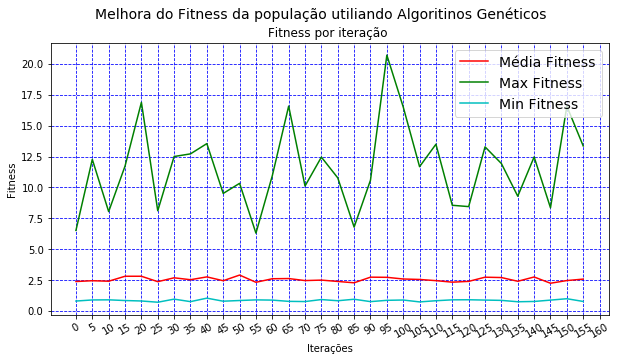

In [96]:
#plot fitnessPerGeneration
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
#set title of the graph/plot
ax.set_title('Fitness por iteração ')
#ax.set_xlabel('Date')
ax.plot(avgFitnessPerGeneration, 'r', label='Média Fitness')
ax.plot(maxFitnessPerGeneration, 'g', label='Max Fitness')
ax.plot(minFitnessPerGeneration, 'c', label='Min Fitness')
ax.legend(loc='best', prop={'size': 14}) 
_ = fig.suptitle('Melhora do Fitness da população utiliando Algoritinos Genéticos', fontsize=14)
ax.grid(color = 'b', linestyle='--')
xticks = list(range(0,len(maxFitnessPerGeneration)+1,1))
xticklabels = [x*5 for x in xticks]
props = {'xlabel': 'Iterações',
         'xticks': xticks,
         'ylabel': 'Fitness'
        }
_ = ax.set(**props)
labels = ax.set_xticklabels(xticklabels, rotation=30, fontsize='medium')
#Annotation

"""xh = (len(maxFitnessPerGeneration)-2)
yh = np.max(temp_fitness)
_= ax.annotate('Best population selected', 
                xy = (xh, yh), 
                xytext=(ax.get_xlim()[0]+xh-2.5, yh + 0.045),
                arrowprops=dict(facecolor='green', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left', verticalalignment='top', color='blue', size=15
                )"""

#### The most important features that give the best fitness are:

In [97]:
print(np.ravel(house_features[np.argwhere(bestInd)]))

['High' 'Low' 'AdjClose']


**Evaluate with the test set**

In [98]:
def get_predictions_forTest(features):
    #for given feature indexes, this function will get predictions from neural network for the specified features
    mlp = NeuralNetwork(x_train[:,features], y_train)
    predictions = mlp.predict(x_test[:,features])
    return predictions

In [99]:
# get predictions on testset
pred_test = np.frompyfunc(get_predictions_forTest, 1, 1) #Function to get prediction array corresponding to all the slected features
print('pred_test {}'.format(pred_test))

selected_features_test = decode_function(selectedPop) #get selected features by GA
print('selected_features_test {}'.format(selected_features_test))

new_array=selected_features_test
newer_array = np.array([y for y in new_array if 0 not in y.shape])

newer_array

s_predictions_test = pred_test(newer_array) #predicted labels for test set
print('s_predictions_test {}'.format(s_predictions_test))

fitness_of_featuresSets_test = fVec(pred = s_predictions_test, real = y_test) #for every predicted array, get the fitness for each individual

fitness_of_featuresSets_test = fitness_of_featuresSets_test.reshape(fitness_of_featuresSets_test.shape[0],1)  #taking the transpose to get proper dimensions for future computations

pred_test <ufunc '? (vectorized)'>
selected_features_test [array([1]) array([0, 1, 2, 3, 4]) array([0, 1, 3, 4]) array([0, 2, 4])
 array([0, 1, 3]) array([0, 1, 3, 4]) array([0, 1, 3, 4]) array([0, 1, 4])
 array([1, 4]) array([0, 1, 3, 4]) array([0, 3, 4]) array([1, 3])
 array([1, 3, 4]) array([1, 2, 3]) array([0, 1, 3, 4]) array([0, 1, 2, 4])
 array([0, 3, 4]) array([1, 3]) array([0, 1, 2, 3]) array([0, 1, 3])
 array([2]) array([1, 2, 3]) array([1, 2, 4]) array([0, 1, 4])
 array([0, 1, 4]) array([0, 1, 4]) array([0, 3, 4]) array([0, 2, 4])
 array([0, 1, 3, 4]) array([0, 1, 2, 3, 4]) array([3, 4]) array([0, 1, 4])
 array([0, 3, 4]) array([0, 2, 4]) array([0, 2, 3, 4]) array([0, 1])
 array([1, 3, 4]) array([0, 3, 4]) array([1, 4]) array([0, 1, 2, 4])
 array([4]) array([0, 2, 4]) array([0, 2, 3, 4]) array([0, 2, 3])
 array([1, 3, 4]) array([1, 4]) array([0, 1, 3, 4]) array([0, 2, 3])
 array([0, 3, 4]) array([1, 2, 3]) array([0, 1, 3]) array([0, 1, 2, 3, 4])
 array([0, 1, 3, 4]) array([0,

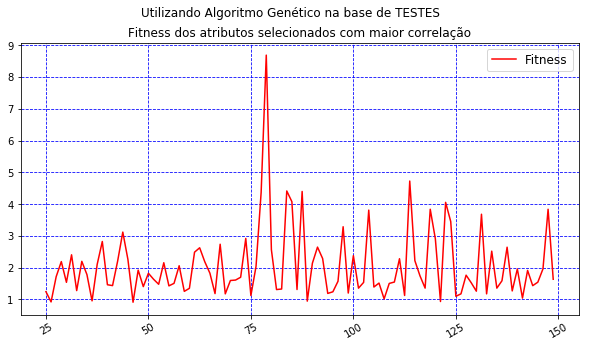

In [101]:
#plot fitness_of_featuresSets_test
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
#set title of the graph/plot
ax.set_title('Fitness dos atributos selecionados com maior correlação')

ax.plot(fitness_of_featuresSets_test, 'r', label='Fitness')
ax.legend(loc='best', prop={'size': 12}) 
_ = fig.suptitle('Utilizando Algoritmo Genético na base de TESTES', fontsize=12)
ax.grid(color = 'b', linestyle='--')
xticks = list(range(0,len(fitness_of_featuresSets_test)+1,5))
xticklabels = [x*5 for x in xticks]

labels = ax.set_xticklabels(xticklabels, rotation=30, fontsize='medium')

In [102]:
# Denormalize data after normalizing to get original scale of values

def denormalize(dataset, scaled_data):
    dataset = dataset['Close'].values.reshape(-1,1)
    normalized_data = scaled_data.reshape(-1,1)
    scaler = StandardScaler()
    scaler.fit_transform(dataset)
    return scaler.inverse_transform(normalized_data)

In [103]:
# denormalize y test and predictions
de_y_test = denormalize(testset, y_test)
de_pred = denormalize(testset, s_predictions_test)
# de_pred = np.abs(de_pred)
# make the predictions array flat
fitness_values = np.ravel(fitness_of_featuresSets_test)

de_pred_max = de_pred[np.argmax(fitness_values)][0] # predictions with max fitness in selected features set
de_pred_min = de_pred[np.argmin(fitness_values)][0] # and min fitness

# index of fitness value that's nearest to the average fitness of selected features set
average_idx = (np.abs(fitness_values - np.average(fitness_values))).argmin()
de_pred_average = de_pred[average_idx][0]

In [104]:
def plot_test_result(pred, test_y, fra=0, color='blue', label='predictions'):
    #Plotting real value against prediction value over a period
    fig = plt.figure(1, figsize=(8,4))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("Predição dos preços de fechamento da empresa Google", fontsize=12)
    ax.plot(test_y[fra:], color='red', label='Valor real', linewidth=1)
    ax.plot(pred[fra:], color=color, label=label, linewidth=1)
        
    ax.legend(loc='best')
    plt.ylabel('Preço')
    plt.show()

In [105]:
def mse_result(test, pred):
    MSE = mean_squared_error(test , pred) 
    RMSE = np.sqrt(MSE)
    fitness = 1/RMSE
    print("MSE %.4f"% MSE)
    print("RMSE %.4f"% RMSE)
    print("Fitness %.8f"% fitness)

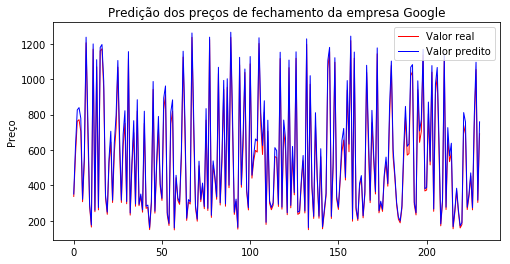

In [115]:
plot_test_result(de_pred_max, de_y_test, fra=600, label='Valor predito')

In [107]:
mse_result(de_y_test , de_pred_max)

MSE 1299.1897
RMSE 36.0443
Fitness 0.02774366


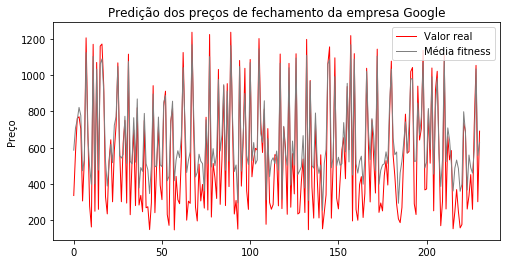

In [108]:
plot_test_result(de_pred_average, de_y_test, fra=600, color='gray', label='Média fitness')

In [109]:
mse_result(de_y_test , de_pred_average)

MSE 23122.3051
RMSE 152.0602
Fitness 0.00657634


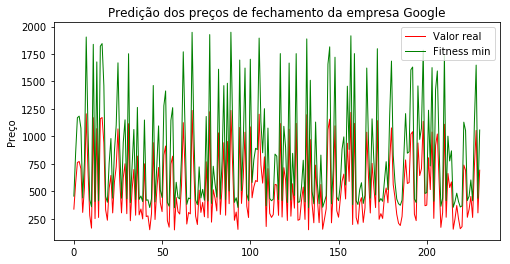

In [110]:
plot_test_result(de_pred_min, de_y_test, fra=600, color='green', label='Fitness min')

In [111]:
mse_result(de_y_test , de_pred_min)

MSE 118134.8664
RMSE 343.7075
Fitness 0.00290945


### Prices's prediction without feature selection:

In [112]:
# create mlp model, then we fit the training data to the model and we use x_test to get the predictions
mlp = MLPRegressor(hidden_layer_sizes=(10),activation='relu',solver='lbfgs',max_iter=1,)
mlp.fit(x_train, y_train)  
pred = mlp.predict(x_test)

In [113]:
# Denormalize the data to get the original scale of values
de_pred = denormalize(testset, pred)
mse_result(de_y_test, de_pred)

MSE 46178.4457
RMSE 214.8917
Fitness 0.00465351


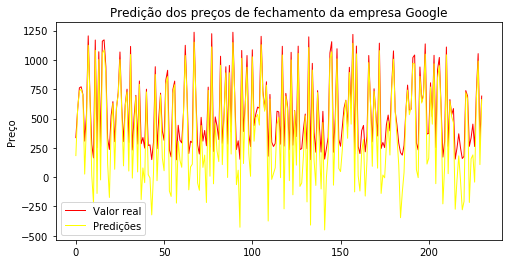

In [114]:
# Plot real values against prediction values 
plot_test_result(de_pred, de_y_test, fra=600, color='yellow', label='Predições')